In [1]:
import wfdb

In [2]:
dbs = wfdb.io.get_record_list('ltmm')

In [3]:
t_min = 60
fps = 200
t_frame = t_min * 60 * fps
rec = wfdb.io.rdrecord(dbs[0], sampfrom=0, sampto=t_frame)

In [4]:
rec

In [5]:
rec.sig_name

['v-acceleration',
 'ml-acceleration',
 'ap-acceleration',
 '/s 0 0 -1124 3453 0 yaw-velocity',
 '/s 0 0 -883 -9724 0 pitch-velocity',
 '/s 0 0 634 -26911 0 roll-velocity']

In [6]:
signal = rec.p_signal

In [7]:
print(signal.shape)

(720000, 6)


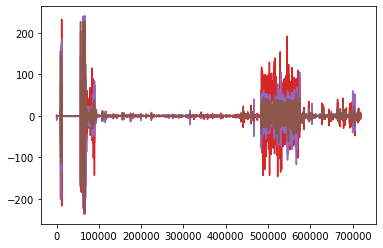

In [8]:
import matplotlib.pyplot as plt
for i in range(6):
    plt.plot(signal[:,i])
plt.show()

In [9]:
def minutes2frames(t_minutes, fps=100):
    return t_minutes*fps*60

def grab_window(dbs, irec = 0, fstart = 0, fclose = 2500):
    rec = wfdb.io.rdrecord( dbs[irec], 
                            sampfrom=fstart, 
                            sampto=fclose    )
    return rec.p_signal, rec.sig_name

def plot_window(dbs, irec = 0, fstart = 0, fclose = 2500,
               acc = True, rot = True):
    clip, head = grab_window(dbs, irec = irec, 
                             fstart = fstart, fclose = fclose )
    c1 = "blue"
    c2 = "green"
    if acc and rot:
        fig, ax1 = plt.subplots()
        c1 = "blue"
        ax1.set_xlabel('time (frames)')
        ax1.set_ylabel('accelerations', color = c1)
        for i in range(3):
            ax1.plot(clip[:,i], label=head[i], color = c1)
        
        ax2 = ax1.twinx()
        ax2.set_ylabel("rotations", color = c2)
        for i in range(3):
            ax2.plot(clip[:,i+3], label=head[i+3], color = c2)

        fig.tight_layout()
    if acc and not rot:
        plt.xlabel('time (frames)')
        plt.ylabel('accelerations', color = c1)
        for i in range(3):
            plt.plot(clip[:,i], label=head[i], color = c1)
            
    if rot and not acc:
        plt.xlabel('time (frames)')
        plt.ylabel('rotations', color = c2)
        for i in range(3):
            plt.plot(clip[:,i+3], label=head[i+3], color = c2)
    
#     plt.legend()
    plt.show()
    plt.clf()

clip, head = grab_window(dbs)

In [10]:
clip.shape

(2500, 6)

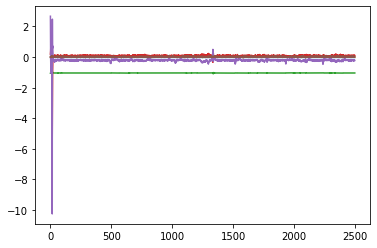

In [11]:
plt.plot(clip)

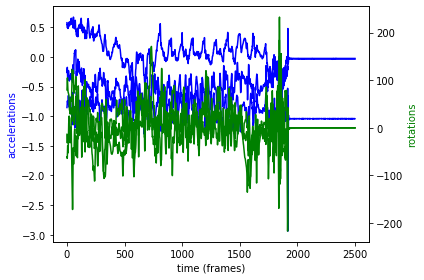

<Figure size 432x288 with 0 Axes>

In [12]:
fstart = 10000
ftotal = 2500
fclose = fstart + ftotal
plot_window(dbs, fstart = fstart, fclose = fclose )

In [13]:
from tensorflow.keras.models import model_from_json
import h5py
import os
# serialize model to JSON
def save_model(model):
    model_json = model.to_json()
    with open("model_100.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("model_100.h5")
    print("Saved model to disk")
    
def load_model(fstr = "model"):
    loc = os.path.abspath("/home/apatch/Documents/Insight/wobblewatch/models")
    fjson = "%s/%s.json" % (loc, fstr)
    fh5   = "%s/%s.h5" % (loc, fstr)
    json_file = open(fjson, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(fh5)
    print("Loaded model from disk")
    return loaded_model

model = load_model(fstr = "model_cnn_200")

Loaded model from disk


In [14]:
df, header = grab_window(dbs, irec = 0, fstart = 0, fclose = 256)

In [15]:
df.shape

(256, 6)

(256, 6) (512, 6)
(256,) (512,)


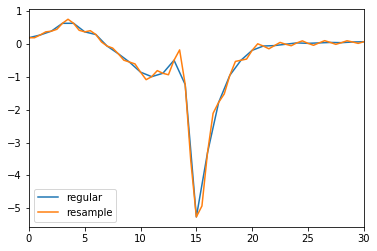

array([[-0.02430932, -0.00709566, -1.05035309,  0.19197293,  2.66644846,
         0.00706453],
       [-0.02239338, -0.00691597, -1.05367   ,  0.19138965,  2.05714311,
        -0.00439768],
       [-0.0214494 , -0.00709566, -1.05905317,  0.27424704,  0.83943748,
        -0.01412905],
       ...,
       [-0.02380142, -0.01067618, -1.0395495 ,  0.01346675, -0.86462658,
         0.0144137 ],
       [-0.02430932, -0.00993393, -1.04165302,  0.06170558, -0.2045688 ,
         0.02119358],
       [-0.0250431 , -0.00818669, -1.04657842,  0.16741755,  1.59773113,
         0.01730309]])

In [17]:
from scipy import signal
import numpy as np
x = np.arange(0,len(df),1)
df2 = signal.resample(df,2*len(df))
print(df.shape, df2.shape)
x2 = np.arange(0,len(df),0.5)
print(x.shape, x2.shape)
plt.plot(x, df[:,3], label="regular")
plt.plot(x2, df2[:,3], label="resample")
plt.xlim([0,30])
plt.legend()
plt.show()
df2

In [52]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

def grab_windows(dbs, irec = 0, start = 0, end = 60, 
                 fps = 100, stride = 200):
    resample = fps / 200
    windows = []
    n_frames = (end - start)*fps
    n_strides = int(n_frames / stride)
    
    for i in range(n_strides):
        _fs = start + i*stride
        _fc = _fs + int(256*resample)
        _df, _head = grab_window(dbs, irec = irec, fstart = _fs, fclose = _fc)
        if resample != 1:
            _df = signal.resample(_df,256)
        windows.append(_df)
    return np.array(windows)
    
def evaluate_windows(dbs, irec = 0, start = 0, end = 60, fps = 100, stride = 256):
    _windows = grab_windows(dbs, irec = irec, 
                            start = start, end = end, 
                            fps = fps, stride = stride)
    results = model.predict(_windows)
#     results[:,0] = results[:,0] * 4
    return np.argmax(results, axis=1)

def grab_hours(dbs, irec = 0, hour_start = 0, hour_end = 24):
    results = []
    for i in range(hour_start, hour_end):
        t_start = i * 60*60
        t_end = (i+1) * 60*60
        print("Hour ", i+1)
        results.extend(evaluate_windows(dbs, irec = irec, 
                                        start = t_start, end = t_end))
    return results

In [53]:
results = grab_hours(dbs, irec=50)

Hour  1
Hour  2
Hour  3
Hour  4
Hour  5
Hour  6
Hour  7
Hour  8
Hour  9
Hour  10
Hour  11
Hour  12
Hour  13
Hour  14
Hour  15
Hour  16
Hour  17
Hour  18
Hour  19
Hour  20
Hour  21
Hour  22
Hour  23
Hour  24


Text(0.5, 0, 'time (min)')

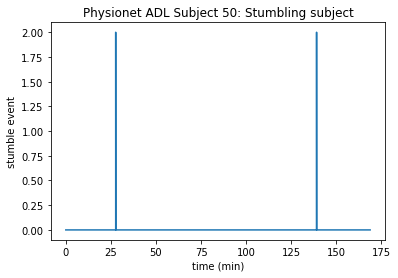

In [54]:
t = np.arange(0,len(results),1) / 200
plt.plot(t,results)
plt.title("Physionet ADL Subject 50: Stumbling subject")
plt.ylabel("stumble event")
plt.xlabel("time (min)")

1 CO002
Hour  1
Hour  2
Hour  3
Hour  4
Hour  5
Hour  6
Hour  7
Hour  8
Hour  9
Hour  10
Hour  11
Hour  12
Hour  13
Hour  14
Hour  15
Hour  16
Hour  17
Hour  18
Hour  19
Hour  20
Hour  21
Hour  22
Hour  23
Hour  24
Hour  25
Hour  26
Hour  27
Hour  28
Hour  29
Hour  30
Hour  31
Hour  32
Hour  33
Hour  34
Hour  35
Hour  36
Hour  37
Hour  38
Hour  39
Hour  40
Hour  41
Hour  42
Hour  43
Hour  44
Hour  45
Hour  46
Hour  47
Hour  48
Hour  49
Hour  50
Hour  51
Hour  52
Hour  53
Hour  54
Hour  55
Hour  56
Hour  57
Hour  58
Hour  59
Hour  60
Hour  61
Hour  62
Hour  63
Hour  64
Hour  65
Hour  66
Hour  67
Hour  68
Hour  69
Hour  70
Hour  71
Hour  72


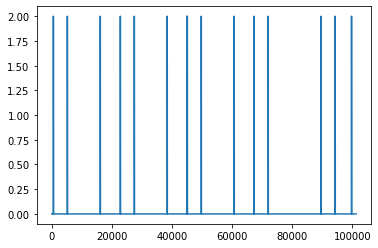

11 CO012
Hour  1
Hour  2
Hour  3
Hour  4
Hour  5
Hour  6
Hour  7
Hour  8
Hour  9
Hour  10
Hour  11
Hour  12
Hour  13
Hour  14
Hour  15
Hour  16
Hour  17
Hour  18
Hour  19
Hour  20
Hour  21
Hour  22
Hour  23
Hour  24
Hour  25
Hour  26
Hour  27
Hour  28
Hour  29
Hour  30
Hour  31
Hour  32
Hour  33
Hour  34
Hour  35
Hour  36
Hour  37
Hour  38
Hour  39
Hour  40
Hour  41
Hour  42
Hour  43
Hour  44
Hour  45
Hour  46
Hour  47
Hour  48
Hour  49
Hour  50
Hour  51
Hour  52
Hour  53
Hour  54
Hour  55
Hour  56
Hour  57
Hour  58
Hour  59
Hour  60
Hour  61
Hour  62
Hour  63
Hour  64
Hour  65
Hour  66
Hour  67
Hour  68
Hour  69
Hour  70
Hour  71
Hour  72


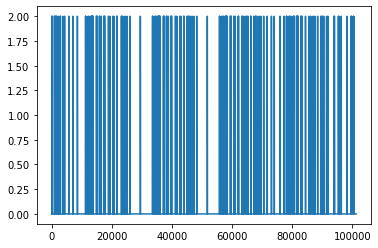

21 CO022
Hour  1
Hour  2
Hour  3
Hour  4
Hour  5
Hour  6
Hour  7
Hour  8
Hour  9
Hour  10
Hour  11
Hour  12
Hour  13
Hour  14
Hour  15
Hour  16
Hour  17
Hour  18
Hour  19
Hour  20
Hour  21
Hour  22
Hour  23
Hour  24
Hour  25
Hour  26
Hour  27
Hour  28
Hour  29
Hour  30
Hour  31
Hour  32
Hour  33
Hour  34
Hour  35
Hour  36
Hour  37
Hour  38
Hour  39
Hour  40
Hour  41
Hour  42
Hour  43
Hour  44
Hour  45
Hour  46
Hour  47
Hour  48
Hour  49
Hour  50
Hour  51
Hour  52
Hour  53
Hour  54
Hour  55
Hour  56
Hour  57
Hour  58
Hour  59
Hour  60
Hour  61
Hour  62
Hour  63
Hour  64
Hour  65
Hour  66
Hour  67
Hour  68
Hour  69
Hour  70
Hour  71
Hour  72


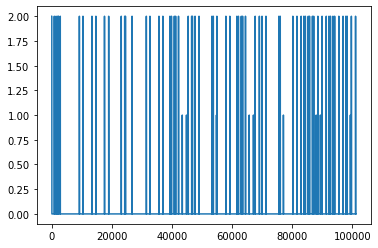

31 CO035
Hour  1
Hour  2
Hour  3
Hour  4
Hour  5
Hour  6
Hour  7
Hour  8
Hour  9
Hour  10
Hour  11
Hour  12
Hour  13
Hour  14
Hour  15
Hour  16
Hour  17
Hour  18
Hour  19
Hour  20
Hour  21
Hour  22
Hour  23
Hour  24
Hour  25
Hour  26
Hour  27
Hour  28
Hour  29
Hour  30
Hour  31
Hour  32
Hour  33
Hour  34
Hour  35
Hour  36
Hour  37
Hour  38
Hour  39
Hour  40
Hour  41
Hour  42
Hour  43
Hour  44
Hour  45
Hour  46
Hour  47
Hour  48
Hour  49
Hour  50
Hour  51
Hour  52
Hour  53
Hour  54
Hour  55
Hour  56
Hour  57
Hour  58
Hour  59
Hour  60
Hour  61
Hour  62
Hour  63
Hour  64
Hour  65
Hour  66
Hour  67
Hour  68
Hour  69
Hour  70
Hour  71
Hour  72


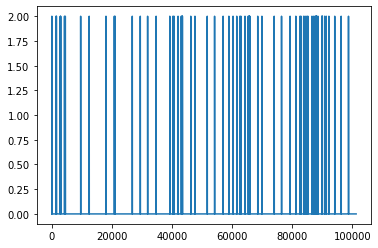

41 FL004
Hour  1
Hour  2
Hour  3
Hour  4
Hour  5
Hour  6
Hour  7
Hour  8
Hour  9
Hour  10
Hour  11
Hour  12
Hour  13
Hour  14
Hour  15
Hour  16
Hour  17
Hour  18
Hour  19
Hour  20
Hour  21
Hour  22
Hour  23
Hour  24
Hour  25
Hour  26
Hour  27
Hour  28
Hour  29
Hour  30
Hour  31
Hour  32
Hour  33
Hour  34
Hour  35
Hour  36
Hour  37
Hour  38
Hour  39
Hour  40
Hour  41
Hour  42
Hour  43
Hour  44
Hour  45
Hour  46
Hour  47
Hour  48
Hour  49
Hour  50
Hour  51
Hour  52
Hour  53
Hour  54
Hour  55
Hour  56
Hour  57
Hour  58
Hour  59
Hour  60
Hour  61
Hour  62
Hour  63
Hour  64
Hour  65
Hour  66
Hour  67
Hour  68
Hour  69
Hour  70
Hour  71
Hour  72


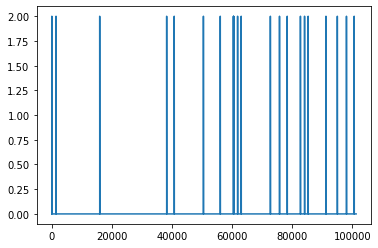

51 FL016
Hour  1
Hour  2
Hour  3
Hour  4
Hour  5
Hour  6
Hour  7
Hour  8
Hour  9
Hour  10
Hour  11
Hour  12
Hour  13
Hour  14
Hour  15
Hour  16
Hour  17
Hour  18
Hour  19
Hour  20
Hour  21
Hour  22
Hour  23
Hour  24
Hour  25
Hour  26
Hour  27
Hour  28
Hour  29
Hour  30
Hour  31
Hour  32
Hour  33
Hour  34
Hour  35
Hour  36
Hour  37
Hour  38
Hour  39
Hour  40
Hour  41
Hour  42
Hour  43
Hour  44
Hour  45
Hour  46
Hour  47
Hour  48
Hour  49
Hour  50
Hour  51
Hour  52
Hour  53
Hour  54
Hour  55
Hour  56
Hour  57
Hour  58
Hour  59
Hour  60
Hour  61
Hour  62
Hour  63
Hour  64
Hour  65
Hour  66
Hour  67
Hour  68
Hour  69
Hour  70
Hour  71
Hour  72


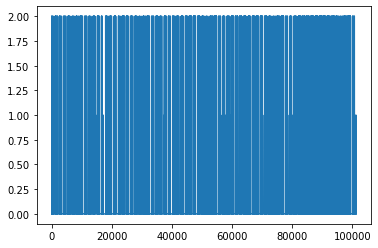

61 FL027
Hour  1
Hour  2
Hour  3
Hour  4
Hour  5
Hour  6
Hour  7
Hour  8
Hour  9
Hour  10
Hour  11
Hour  12
Hour  13
Hour  14
Hour  15
Hour  16
Hour  17
Hour  18
Hour  19
Hour  20
Hour  21
Hour  22
Hour  23
Hour  24
Hour  25
Hour  26
Hour  27
Hour  28
Hour  29
Hour  30
Hour  31
Hour  32
Hour  33
Hour  34
Hour  35
Hour  36
Hour  37
Hour  38
Hour  39
Hour  40
Hour  41
Hour  42
Hour  43
Hour  44
Hour  45
Hour  46
Hour  47
Hour  48
Hour  49
Hour  50
Hour  51
Hour  52
Hour  53
Hour  54
Hour  55
Hour  56
Hour  57
Hour  58
Hour  59
Hour  60
Hour  61
Hour  62
Hour  63
Hour  64
Hour  65
Hour  66
Hour  67
Hour  68
Hour  69
Hour  70
Hour  71
Hour  72


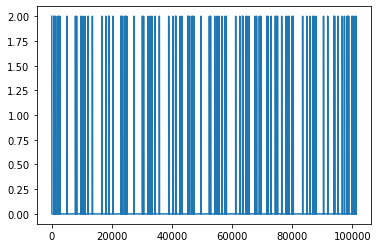

In [73]:
results = {}
for irec in [1,11,21,31,41,51,61]:
    print(irec, dbs[irec])
    results[irec] = grab_hours(dbs, irec=irec, hour_start=0, hour_end=72)
    plt.plot(results[irec])
    plt.show()

In [75]:
for k in results.keys():
    results[k] = np.array(results[k])

In [76]:
for k in results.keys():
    print("%2i %s %3i %3i %4i" % 
          (k, dbs[k],
           len(results[k][results[k] == 1]), 
           len(results[k][results[k] == 2]), 
           len(results[k][results[k] == 0])))

 1 CO002   0  15 101217
11 CO012   9 258 100965
21 CO022  18 102 101112
31 CO035   9  98 101125
41 FL004   3  24 101205
51 FL016 424 788 100020
61 FL027   0 104 101128


In [77]:
for k in results.keys():
    print("%2i %s %5.3f %4i" % 
          (k, dbs[k],
           len(results[k][results[k] == 1])/len(results[k][results[k] == 2]), 
           len(results[k][results[k] == 0])))

 1 CO002 0.000 101217
11 CO012 0.035 100965
21 CO022 0.176 101112
31 CO035 0.092 101125
41 FL004 0.125 101205
51 FL016 0.538 100020
61 FL027 0.000 101128


In [90]:
for k in results.keys():
    total_time = len(results[k])
    time_day = int(total_time/3)
    print(time_day)
    print("%2i %s" % (k, dbs[k]))
    for i in range(3):
        _res = results[k][i*time_day:(i+1)*time_day]
        print(_res.shape)
        n_prefall = len(_res[_res == 1])
        n_fall = len(_res[_res == 2])
        if n_fall == 0: n_fall = 1
        print("    Day %2i %3i %5.3f" % 
          (i+1, n_prefall, float(n_prefall)/n_fall))

33744
 1 CO002
(33744,)
    Day  1   0 0.000
(33744,)
    Day  2   0 0.000
(33744,)
    Day  3   0 0.000
33744
11 CO012
(33744,)
    Day  1   9 0.067
(33744,)
    Day  2   0 0.000
(33744,)
    Day  3   0 0.000
33744
21 CO022
(33744,)
    Day  1   9 0.191
(33744,)
    Day  2   5 0.200
(33744,)
    Day  3   4 0.133
33744
31 CO035
(33744,)
    Day  1   9 0.243
(33744,)
    Day  2   0 0.000
(33744,)
    Day  3   0 0.000
33744
41 FL004
(33744,)
    Day  1   3 0.500
(33744,)
    Day  2   0 0.000
(33744,)
    Day  3   0 0.000
33744
51 FL016
(33744,)
    Day  1 119 0.564
(33744,)
    Day  2 143 0.538
(33744,)
    Day  3 162 0.521
33744
61 FL027
(33744,)
    Day  1   0 0.000
(33744,)
    Day  2   0 0.000
(33744,)
    Day  3   0 0.000


PACE Scores, Falls Year, 6mo, yr almost
CO02  97.50  0, 0, 0
CO12 125.50  1, 1, 1
CO22  98.85  0,0,"more than 1"
CO35  95.69  0,0,0
FL04 104.89  5,2,1
FL16  61.13  6,5,"yes, no number"
FL27  75.00  10,5,0


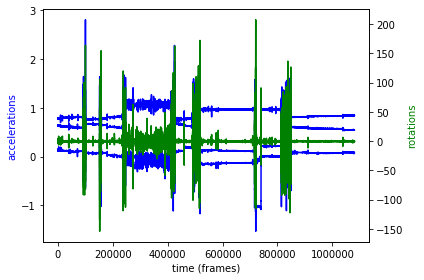

<Figure size 432x288 with 0 Axes>

In [72]:
plot_window(dbs, irec = 1, fstart = 24*60*60*100, fclose = 27*60*60*100, acc = True, rot = True)


CO001
Hour  25
Hour  26
Hour  27
Hour  28
Hour  29
Hour  30
Hour  31
Hour  32
Hour  33
Hour  34
Hour  35
Hour  36
Hour  37
Hour  38
Hour  39
Hour  40
Hour  41
Hour  42
Hour  43
Hour  44
Hour  45
Hour  46
Hour  47
Hour  48


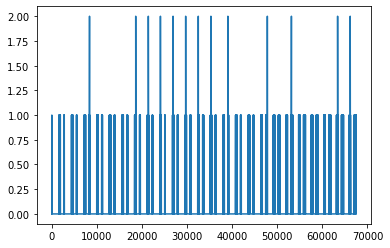

CO002
Hour  25
Hour  26
Hour  27
Hour  28
Hour  29
Hour  30
Hour  31
Hour  32
Hour  33
Hour  34
Hour  35


KeyboardInterrupt: 

In [67]:
for i in range(len(dbs)):
    print(dbs[i])
    results = grab_hours(dbs, irec=i, hour_start=24, hour_end=48)
    plt.plot(results)
    plt.show()

In [ ]:
plot_window(dbs, irec = 25, fstart = 0, fclose = 2*3600*100,
            acc = True, rot = True)

In [ ]:
print(dbs[45])
results = grab_hours(dbs, irec=25, hour_start=0, hour_end=24)
plt.plot(results)